# Promotion Effect Estimation Using Causal Inference Methods

This notebook demonstrates how to analyze causal effects in marketing campaigns. 

### Use Case
We consider a scenario where selected customers were provided (treated) with personalized offers. Our goal is to measure the treatment effect of these offers on conversions (purchases) taking into account factors such as demographics that influence both offer assignments and customers' purchasing decisions. 

### Prototype: Data and Limitations
We use generated data (simulator) to demonstrate the causal inference methods in a clean way. 

### Usage and Productization
This prototype can be used to evaluate causal effects in a real data sample before building predictive promotion targeting or budget optimization models. This template can also be adapted to a wide range of customer communication and personalization scenarios.

It is recommended to start with modifying the data generator to match your use case and data samples. Once the generator is modified, different inference methods can be evaluated and fine-tuned using simulations. Once we are confident that the methods produce valid results for simulated data, we can apply them to the actual data sample.

# Data Generation

We use a basic data generation model with the following variables:
 - `age` - observed customer demographics variable
 - `state` - observed customer demographics variable
 - `is_offer` - indicates customers who were targeted with a special offer  
 - `is_conversion` - indicates conversion after a promotion campaign
    
Both targeting decisions (`is_offer`) and conversions (`is_conversion`) are dependent on demographics. In other words, the demographic variables are the back doors. 

We provide several visualizations that help to understand the correlation between the variables. In particular, these visualization indicate that offers and conversions are positively correlated. This is true even if the `promo_effect` parameter is set to zero. Our goal will be to estimate the real causal effect of the offers on conversions controlling for the back doors.

+----+-------+---------+------------+-----------------+
|    |   age | state   | is_offer   | is_conversion   |
|----+-------+---------+------------+-----------------|
|  0 |    27 | CA      | True       | False           |
|  1 |    32 | TX      | False      | True            |
|  2 |    29 | CA      | False      | False           |
|  3 |    29 | TX      | True       | True            |
|  4 |    25 | NJ      | False      | False           |
+----+-------+---------+------------+-----------------+
+--------+--------------+---------+------------+-----------------+
|        |          age | state   |   is_offer |   is_conversion |
|--------+--------------+---------+------------+-----------------|
| count  | 100000       | 100000  |     100000 |          100000 |
| unique |    nan       | 3       |          2 |               2 |
| top    |    nan       | TX      |          0 |               0 |
| freq   |    nan       | 33611   |      67118 |           79711 |
| mean   |     28.0132  | n

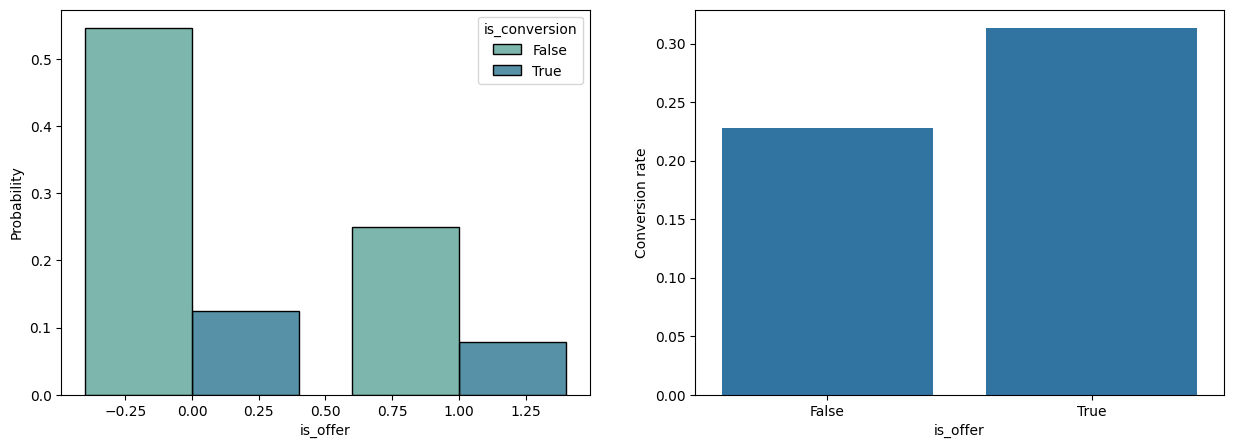

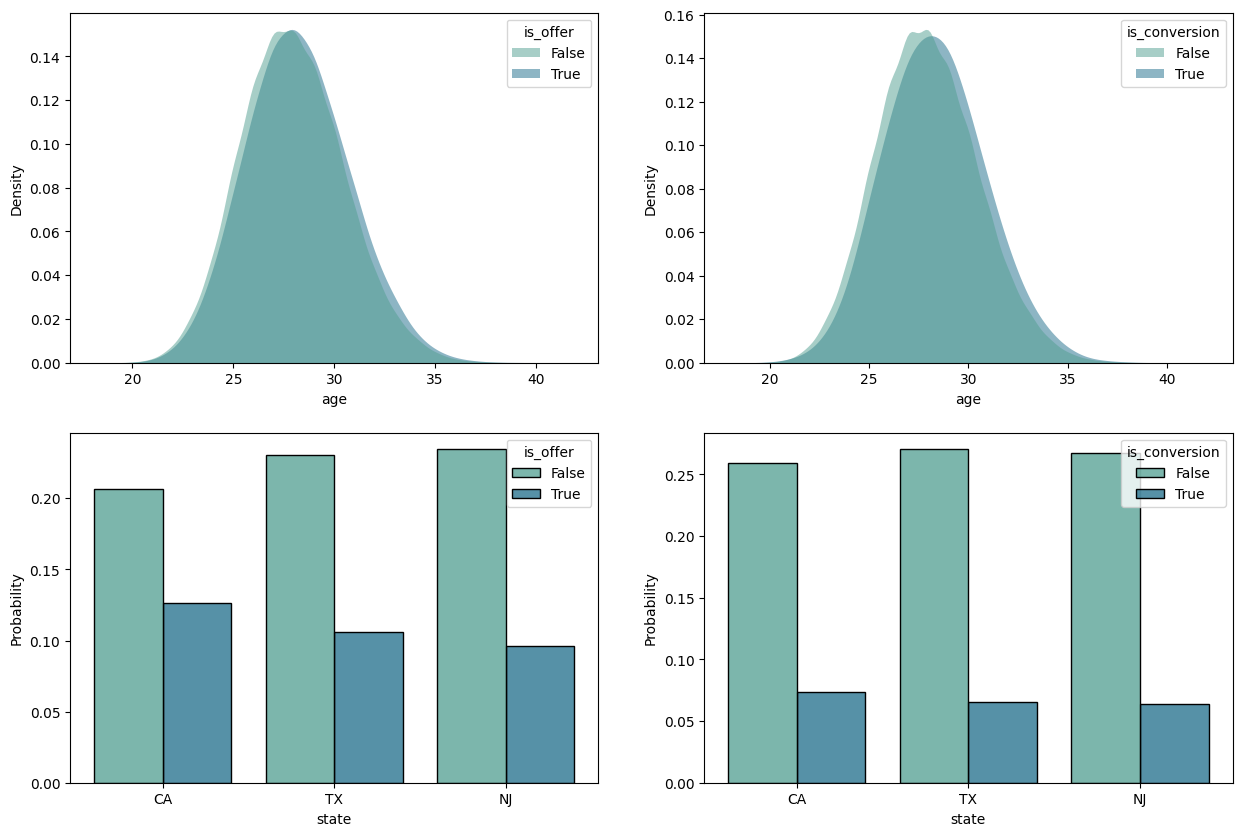

In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler


def print_df(df):
    print(tabulate(df, headers='keys', tablefmt='psql'))

def generate_promotion_data(promo_effect = 0.05, state_effect = 0.02, age_effect = 0.2, n = 100000):
    # Demographic features
    data = pd.DataFrame({
        'age': 20 + np.random.binomial(40, 0.2, n),
        'state': np.random.choice(['CA', 'NJ', 'TX'], n)
    })
    data['age_std'] = MinMaxScaler().fit_transform(np.array(data['age']).reshape(-1,1))

    # Historical promotion campaigns: the offers were targeted based on demographics
    data['is_offer'] = np.random.uniform(size = n) < (
            0.20 +
            0.10 * (data['state'] == 'CA') +
            0.03 * (data['state'] == 'TX') +
            0.01 * (data['state'] == 'NJ') +
            0.20 * (data['age_std'])
    )

    # Outcome depends both on offer and demographic
    data['is_conversion'] = np.random.uniform(size = n) < (
            0.10 +
            promo_effect * data['is_offer'] +
            state_effect * (data['state'] == 'CA') +
            age_effect   * (data['age_std'])
    )
    
    data.drop(columns=['age_std'], inplace=True)
    
    return data

data = generate_promotion_data()

#
# Dataset preview and descriptive statistics
#
print_df(data.head(5))
print_df(data.describe(include='all')) 


#
# Visualize the correlation between offers and conversion rates
#
_, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data=data, x="is_offer", hue="is_conversion", palette="crest", 
             stat="probability", multiple="dodge", shrink=.8, discrete=True, ax=ax[0])
crosstab = pd.crosstab(data["is_offer"], data["is_conversion"])
offer_conversion_rate = crosstab.iloc[:, 1] / crosstab.iloc[:, 0]
sns.barplot(offer_conversion_rate, ax=ax[1])
plt.ylabel("Conversion rate")


#
# Visualize the distributions
#
_, ax = plt.subplots(2, 2, figsize=(15, 10))
for j, y in enumerate(['is_offer', 'is_conversion']):
    sns.kdeplot(
        data=data, x="age", hue=y, bw_adjust=2,
        fill=True, common_norm=False, palette="crest",
        alpha=.5, linewidth=0, ax=ax[0][j]
    )
    sns.histplot(
        data=data, x="state", hue=y, shrink=.8, palette="crest", 
        stat="probability", multiple="dodge", ax=ax[1][j]
    )

# Solution 1: Promotion Effect Estimation Using Regression 

In this section, we use regression to control for back doors and estimate the average treatment effect.

In [388]:
import statsmodels.formula.api as smf 

def get_logit_model(data: pd.DataFrame):
    #
    # Feature engineering
    #
    df = data.copy()
    df['is_offer'] = 1*df['is_offer']
    df['is_conversion'] = 1*df['is_conversion']
    df['age'] = MinMaxScaler().fit_transform(np.array(df['age']).reshape(-1,1))

    #
    # Model fitting 
    #
    model_logit = smf.logit("is_conversion ~ is_offer + C(state) + age", data=df).fit(disp=0) 
    
    return model_logit, df

#
# Create a model and perform diagnostics. The estimated marginal effect should 
# match the true effect specified in the data generator.
#
data = generate_promotion_data(promo_effect=0.3, age_effect=0.0)
logit_model, _ = get_logit_model(data)
print(logit_model.summary())
print(logit_model.get_margeff().summary())

                           Logit Regression Results                           
Dep. Variable:          is_conversion   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99995
Method:                           MLE   Df Model:                            4
Date:                Sat, 02 Dec 2023   Pseudo R-squ.:                  0.1143
Time:                        08:15:49   Log-Likelihood:                -44749.
converged:                       True   LL-Null:                       -50522.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.0090      0.031    -64.499      0.000      -2.070      -1.948
C(state)[T.NJ]    -0.1512      0.020     -7.402      0.000      -0.191      -0.111
C(state)[T.TX]    -0.1512      0.020

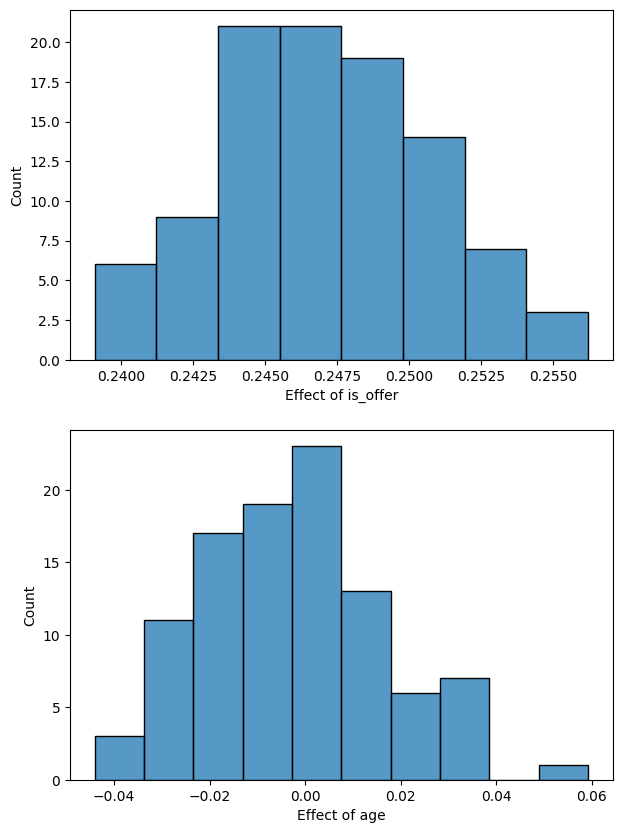

In [389]:
#
# Evaluate the distribution of the effect using bootstrapping
#
_, ax = plt.subplots(2, 1, figsize=(7, 10))
for j, x in enumerate(['is_offer', 'age']):
    effect = []
    for i in range(100):
        df = data.sample(frac=0.2) # bootstrapping
        logit_model, _ = get_logit_model(df)
        effect.append(logit_model.get_margeff().summary_frame()['dy/dx'][x])

    sns.histplot(effect, ax=ax[j])
    ax[j].set_xlabel(f"Effect of {x}")

# Solution 2: Promotion Effect Estimation Using Matching

In this section, we use propensity score matching/weighting to estimate the average treatment effect.

In [430]:
from causalinference.causal import CausalModel
import warnings

data = generate_promotion_data(promo_effect=0.3, age_effect=0.0)

#
# Feature engineering
# 
df = pd.get_dummies(data, columns=['state'])
df['is_conversion'] = df['is_conversion'].astype(int)
df['is_offer'] = df['is_offer'].astype(int)

y = df['is_conversion'].to_numpy()
d = df['is_offer'].to_numpy()
x = df[['age', 'state_CA', 'state_NJ', 'state_TX']].to_numpy().astype(int)

#
# Fit the model and estimate the propensity scores
#
warnings.filterwarnings('ignore')
model = CausalModel(y, d, x)
model.est_propensity()
model.trim_s()

#
# Estimate the treatment effect using build-in functionality 
#
model.est_via_weighting()
print(model.estimates)

#
# Alternatively, we can estimate the treatment effect using hand-coded regression with inverse propensity weights
#
df['ps'] = model.propensity['fitted']
df['ipw'] = df['is_conversion'] *(1/df['ps']) + (1 - df['is_conversion'])*(1/(1 - df['ps']))
m = smf.wls(formula='is_conversion ~ C(is_offer)', weights=df['ipw'], data=df[['is_conversion', 'is_offer']]).fit()
print(m.summary())


Treatment Effect Estimates: Weighting

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE      0.302      0.003    100.127      0.000      0.296      0.308
                            WLS Regression Results                            
Dep. Variable:          is_conversion   R-squared:                       0.155
Model:                            WLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                 1.834e+04
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:31:21   Log-Likelihood:                -62279.
No. Observations:              100000   AIC:                         1.246e+05
Df Residuals:                   99998   BIC:                         1.246e+05
Df Model:                           1                                         
Covari